# **NUS Statistics and Data Science Society (SDS)**

### Datathon 2026

---

**Category:** <span style="color:green">A</span>

**Team:** <span style="color:orange">double mcspicy meal upsized 🍔🥤</span>

**Members:** Koh Hong Yao, Lin Myat, Parama Roy Poja, Peng Rui Biao


## 0. Environment Set-up

### 0.1. Python Imports

We modularise preprocessing, feature engineering, and analytics logic into separate files to improve reproducibility, readability, and experimentation speed — a common best practice in real-world data science workflows.


In [1]:
import sys
sys.path.append("./src")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from preprocessing import load_data, basic_cleaning, coerce_numeric_columns, handle_missing_values, handle_range_values
from feature_engineering import create_features, log_transform
from clustering import run_kmeans
from anomaly import detect_anomalies
from similarity import compute_similarity, get_top_peers
from insights import generate_insights

from config import (
    NUMERIC_COLS,
    CATEGORICAL_COLS,
    RANGE_COLS,
    CURRENT_YEAR,
    RANDOM_STATE
)

### 0.2. Loading dataset + Data Preprocessing

We begin by loading the raw dataset from the provided Excel file and applying a sequence of preprocessing steps to ensure the data is clean, consistent, and suitable for downstream analysis. The initial cleaning process standardises column names, removes duplicate records, and resolves common formatting issues that may arise from heterogeneous data sources. This establishes a consistent schema across the dataset and reduces the risk of downstream errors. Next, we explicitly coerce known numeric columns into numeric data types. This step is _critical_ to prevent silent type-related issues, such as numerical values being interpreted as strings, which could otherwise compromise statistical analysis and feature engineering.

Missing values in numeric columns are then handled using domain-appropriate strategies to preserve as much information as possible while maintaining data integrity. Addressing missingness at this stage ensures that subsequent transformations and models operate on stable inputs. We also standardise range-based fields (such as employee count ranges) by converting them into usable numerical representations. This enables these variables to be incorporated meaningfully into quantitative analysis and distance-based methods. Finally, we perform a quick sanity check by inspecting the dataset’s shape and previewing the first few rows to verify that preprocessing has been applied correctly and that the resulting dataset is ready for exploratory data analysis.

**Why this matters:**
This ensures that all downstream analysis is performed on consistent, machine-readable numerical features, preventing errors during feature engineering, clustering, and distance-based analysis.


In [2]:
df = load_data("./data/champions_group_data.xlsx")
df = basic_cleaning(df)
df = coerce_numeric_columns(df, NUMERIC_COLS)
df = handle_missing_values(df, NUMERIC_COLS)
df = handle_range_values(df, RANGE_COLS)

df.shape, df.head()


/Users/pojaroy/Desktop/datathon/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1213: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


((8559, 83),
    DUNS Number  Company Sites Website  \
 0    639677726            NaN     NaN   
 1    547756179            NaN     NaN   
 2    728834216            NaN     NaN   
 3    728791839            NaN     NaN   
 4    728889244            NaN     NaN   
 
                                       Address Line 1  \
 0  No.2777 Taidong Road, Panyang Industrial Park,...   
 1  No.306, Building 8, Shuangyushudongli Jia, Hai...   
 2  South of Siduan Road, Xi Street, Keshan Town, ...   
 3  Songaoliang Village, Liaoyang Town, Zuoquan Co...   
 4  No.14, Chengyadao Alley, Zuoquan County       ...   
 
                              City                           State  \
 0  Suzhou                          Jiangsu                          
 1  Beijing                         Beijing                          
 2  Qiqihar                         Heilongjiang                     
 3  Jinzhong                        Shanxi                           
 4  Jinzhong                        Sha

## 1. Exploratory Data Analysis


### 1.1. Numerical Analysis

The numerical summary reveals a highly heterogeneous dataset spanning firm size, financial scale, and operational characteristics.

Employee-related variables (`Employees Single`, `Employees Total`) exhibit strong right-skewness, with medians of only 4 employees and upper quartiles around 21, contrasted against extreme maximum values exceeding 3,000. This indicates a population dominated by micro- and small-sized entities, alongside a small number of very large organisations. Such skewness motivates the use of log transformations and scale-normalised features in subsequent analysis.

Financial variables, including `Revenue (USD)`, `Market Value`, `IT Budget`, and `IT spend`, display even greater dispersion. While median revenues are in the hundreds of thousands of USD, maximum values reach into the billions, highlighting the presence of extreme outliers. The large gap between means and medians further confirms heavy-tailed distributions, suggesting that raw financial figures alone would disproportionately weight large firms in distance-based methods.

The `Year Founded` variable shows that most firms are relatively young, with a median founding year of 2019 and an interquartile range between 2012 and 2023. This indicates a dataset skewed toward newer companies, which may influence patterns in firm size, efficiency, and technology adoption.

Certain variables, such as `Corporate Family Size`, also demonstrate extreme maxima (e.g. values near 100,000), implying the presence of large corporate group structures alongside standalone entities. This introduces additional structural heterogeneity beyond simple firm size.

Geographic variables (`Latitude`, `Longitude`) contain extreme values well outside valid coordinate ranges, suggesting placeholder values, encoding issues, or aggregation artefacts. These variables are therefore unsuitable for direct numerical modelling without further cleaning or validation and are treated cautiously in downstream analysis.

Overall, the numerical analysis highlights **substantial skewness, outliers, and multi-scale behaviour** across key variables. This strongly justifies the use of log transformations, engineered efficiency metrics (e.g. per-employee measures), and robust feature selection to ensure meaningful clustering and comparison across firms.


In [3]:
df[NUMERIC_COLS].describe().T

,count,mean,std,min,25%,50%,75%,max
Employees Single Site,8559.0,2.266199e+01,9.968875e+01,0.000000,0.00000,4.00000,2.100000e+01,3.290000e+03
Employees Total,8559.0,2.265755e+01,9.968921e+01,0.000000,0.00000,4.00000,2.100000e+01,3.290000e+03
Revenue (USD),8559.0,3.960699e+06,4.510212e+07,0.000000,0.00000,443445.00000,2.099812e+06,2.961727e+09
Year Found,8559.0,2.015465e+03,2.385699e+01,0.000000,2012.00000,2019.00000,2.023000e+03,2.024000e+03
Corporate Family Members,8559.0,5.828473e+02,4.283483e+03,0.000000,2.00000,5.00000,2.800000e+01,9.999900e+04
Market Value (USD),8559.0,9.362241e+06,5.156963e+07,0.000000,0.00000,344055.00000,6.675812e+06,1.759816e+09
IT Budget,8559.0,1.400725e+05,8.617875e+05,0.000000,0.00000,26213.00000,1.117230e+05,5.103818e+07
IT spend,8559.0,8.683155e+04,5.343089e+05,0.000000,0.00000,16252.00000,6.926800e+04,3.164367e+07
Lattitude,8559.0,6.780687e+02,4.323523e+04,-6.354780,28.19937,28.19937,2.819937e+01,3.304278e+06
Longitude,8559.0,1.539067e+03,1.206069e+05,-85.273548,108.92861,108.92861,1.089286e+02,1.109972e+07


### 1.2. Missingness Analysis

An analysis of column-level missingness reveals that several variables exhibit insufficient data coverage to support reliable modeling or inference. Columns with more than 80% missing values are highlighted in orange in the visualization to indicate limited analytical usability. These variables were excluded from subsequent analysis, as their high degree of missingness would introduce noise and reduce model robustness.

The removed columns include `Ticker`, `Registration Number Type`, `Manufacturing Status`, `Website`, `ANZSIC Code`, `ANZSIC Description`, `Is Headquarters`, `NACE Rev 2 Description`, `ISIC Rev 4 Description`, `ISIC Rev 4 Code`, `Is Domestic Ultimate`, `NACE Rev 2 Code` and, `Phone Number`.


In [4]:
missing_summary = pd.DataFrame({
    "missing_rate": df.isna().mean(),
    "non_missing_count": df.notna().sum()
}).sort_values("missing_rate", ascending=False)

missing_summary[missing_summary["missing_rate"] > 0].head(10)


,missing_rate,non_missing_count
Company Sites,1.000000,0
Ticker,0.999533,4
Registration Number Type,0.999065,8
Manufacturing Status,0.969506,261
Website,0.926977,625
ANZSIC Code,0.833392,1426
ANZSIC Description,0.833158,1428
Is Headquarters,0.828601,1467
NACE Rev 2 Description,0.823344,1512
NACE Rev 2 Code,0.823110,1514


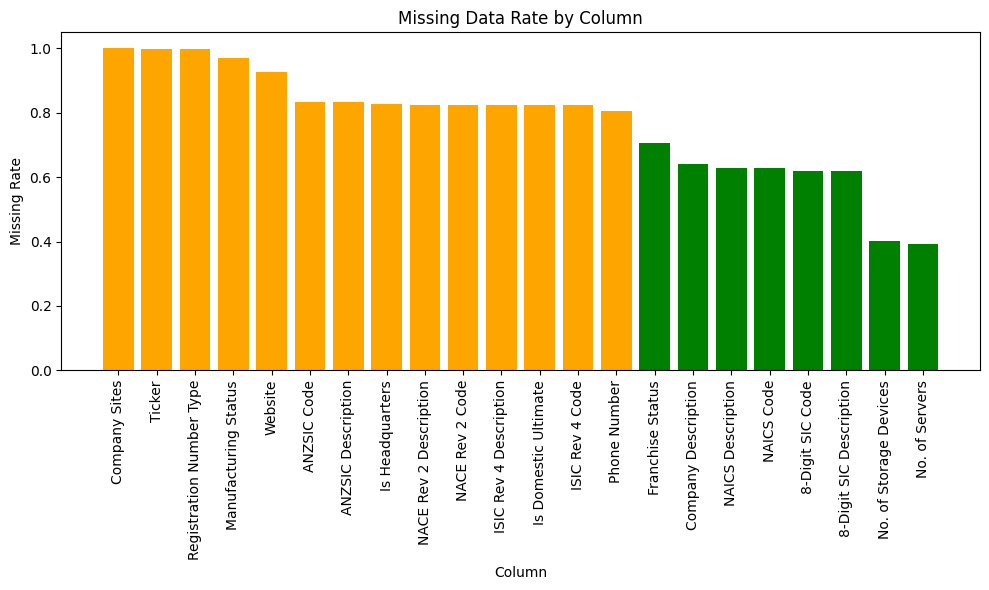

In [5]:
top_n = 22
missing_plot = missing_summary[missing_summary["missing_rate"] > 0].head(top_n)

colors = [
    "orange" if rate >= 0.8 else "green"
    for rate in missing_plot["missing_rate"]
]

plt.figure(figsize=(10, 6))
plt.bar(
    missing_plot.index,
    missing_plot["missing_rate"],
    color=colors
)
plt.ylabel("Missing Rate")
plt.xlabel("Column")
plt.title("Missing Data Rate by Column")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [6]:
high_missing_cols = missing_summary.loc[
    missing_summary["missing_rate"] > 0.8
].index.tolist()

high_missing_cols

['Company Sites',
 'Ticker',
 'Registration Number Type',
 'Manufacturing Status',
 'Website',
 'ANZSIC Code',
 'ANZSIC Description',
 'Is Headquarters',
 'NACE Rev 2 Description',
 'NACE Rev 2 Code',
 'ISIC Rev 4 Description',
 'Is Domestic Ultimate',
 'ISIC Rev 4 Code',
 'Phone Number']

In [7]:
df = df.drop(columns=high_missing_cols)
df.shape, df.head()

((8559, 69),
    DUNS Number                                     Address Line 1  \
 0    639677726  No.2777 Taidong Road, Panyang Industrial Park,...   
 1    547756179  No.306, Building 8, Shuangyushudongli Jia, Hai...   
 2    728834216  South of Siduan Road, Xi Street, Keshan Town, ...   
 3    728791839  Songaoliang Village, Liaoyang Town, Zuoquan Co...   
 4    728889244  No.14, Chengyadao Alley, Zuoquan County       ...   
 
                              City                           State  \
 0  Suzhou                          Jiangsu                          
 1  Beijing                         Beijing                          
 2  Qiqihar                         Heilongjiang                     
 3  Jinzhong                        Shanxi                           
 4  Jinzhong                        Shanxi                           
 
   State Or Province Abbreviation  Postal Code               Country Region  \
 0                           JS       215000.0  CHINA           

## 2. Feature Engineering

To enable meaningful comparison across firms of different sizes, we engineer scale-aware features that capture company maturity, operational efficiency, organisational structure, and IT intensity.

Highly skewed financial and size variables are log-transformed using log(1 + x) to reduce the influence of extreme outliers while retaining zero-valued observations. These transformed features are more suitable for distance-based analysis.

We derive company age to capture organisational maturity and lifecycle stage. To assess efficiency, we compute revenue per employee, log revenue per employee, and IT spend per employee, allowing productivity and technology investment to be evaluated independently of firm size. Employees per site is included as a proxy for operational concentration.

IT infrastructure intensity is summarised through an infrastructure density score, which normalises servers, routers, and storage devices by employee count. Finally, a laptop-to-desktop ratio is introduced to capture differences in workforce mobility and end-user computing environments.

Together, these engineered features move the analysis beyond raw scale, enabling more robust clustering, anomaly detection, and peer comparison.

**Why this matters:**
Raw financial and size metrics obscure operational efficiency and maturity. Engineered features allow us to distinguish how companies operate, not just how large they are.


In [8]:
df = create_features(df)
df = log_transform(df, [
    "Revenue (USD)",
    "Employees Total",
    "IT spend"
])

df[[
    "company_age",
    "revenue_per_employee",
    "it_spend_per_employee",
    "infra_density_score"
]].describe()


,company_age,revenue_per_employee,it_spend_per_employee,infra_density_score
count,8559.000000,8.559000e+03,8.559000e+03,8559.000000
mean,10.534876,1.713609e+06,2.642996e+04,2.089849
std,23.856991,4.220862e+07,2.604450e+05,3.379009
min,2.000000,0.000000e+00,0.000000e+00,0.000000
25%,3.000000,0.000000e+00,0.000000e+00,0.000000
50%,7.000000,3.428100e+04,1.007469e+03,0.634615
75%,14.000000,1.258086e+05,3.947000e+03,1.833333
max,2026.000000,2.961727e+09,1.090622e+07,11.000000


Initial visualisation of revenue-per-employee against firm size revealed extreme skewness driven by firms with very small employee counts. To mitigate small-denominator effects and improve interpretability, efficiency metrics were log-transformed prior to analysis and clustering.


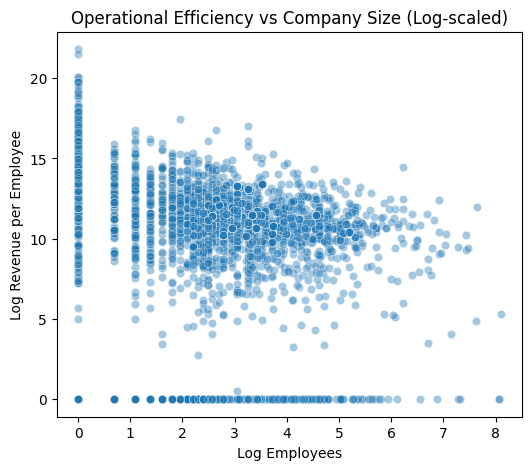

In [9]:
plt.figure(figsize=(6, 5))
sns.scatterplot(
    x=df["log_employees_total"],
    y=df["log_revenue_per_employee"],
    alpha=0.4
)
plt.xlabel("Log Employees")
plt.ylabel("Log Revenue per Employee")
plt.title("Operational Efficiency vs Company Size (Log-scaled)")
plt.show()


To assess the effectiveness of the log transformation and understand the distribution of key scale-related variables, we visualise the distributions of log-transformed employee counts, revenue, and IT spend. These transformations reduce skewness and stabilise variance, making the features more suitable for distance-based methods.

The distributions of log-transformed employee count, revenue, and IT spend reveal a highly heterogeneous firm population dominated by small organisations, alongside a long tail of larger, high-spend firms. While log transformation substantially reduces skewness, the presence of mass near zero indicates a large number of micro-sized entities or branches with minimal reported activity. This highlights the importance of using robust, scale-aware features in downstream clustering and analysis.


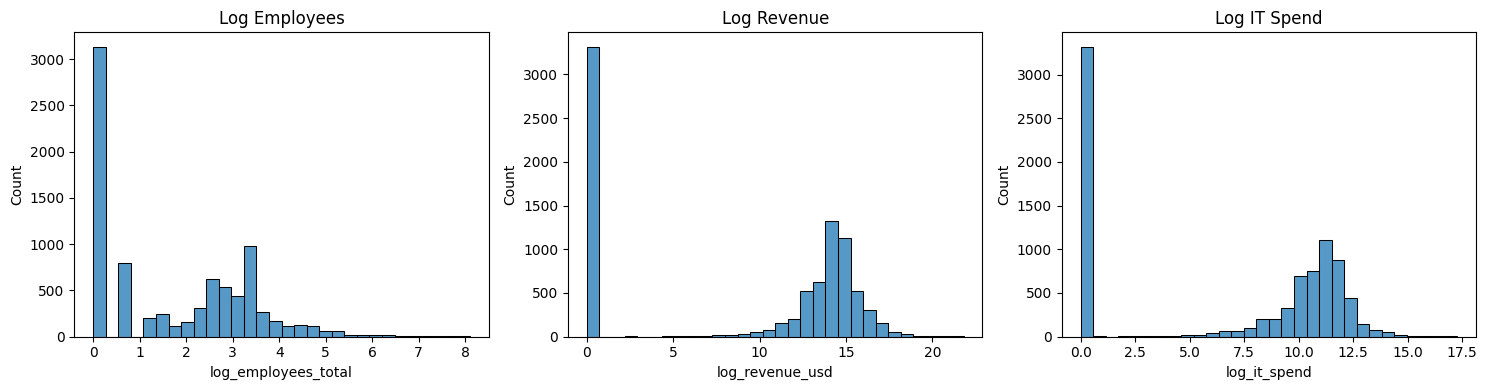

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.histplot(df["log_employees_total"], bins=30, ax=axes[0])
axes[0].set_title("Log Employees")

sns.histplot(df["log_revenue_usd"], bins=30, ax=axes[1])
axes[1].set_title("Log Revenue")

sns.histplot(df["log_it_spend"], bins=30, ax=axes[2])
axes[2].set_title("Log IT Spend")

plt.tight_layout()
plt.show()


We examine correlations among numeric and engineered features to identify potential redundancy and to better understand relationships between firm size, financial scale, and operational efficiency.

The correlation heatmap reveals strong relationships among firm size, revenue, and IT expenditure, indicating that these variables largely capture a common scale dimension. In contrast, company age and infrastructure density exhibit weak correlations with financial and size-related metrics, suggesting that they capture orthogonal aspects of firm behaviour. This supports the inclusion of both scale-driven and operational features in downstream clustering to differentiate companies beyond size alone.


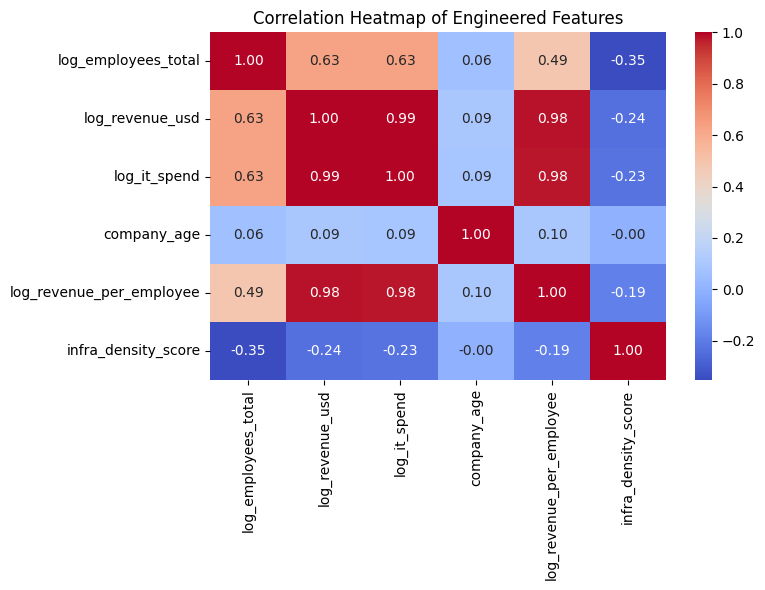

In [11]:
corr_features = [
    "log_employees_total",
    "log_revenue_usd",
    "log_it_spend",
    "company_age",
    "log_revenue_per_employee",
    "infra_density_score"
]

plt.figure(figsize=(8, 6))
sns.heatmap(
    df[corr_features].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)
plt.title("Correlation Heatmap of Engineered Features")
plt.tight_layout()
plt.show()


To explore whether firm maturity is associated with scale, we visualise company age against employee count. This provides insight into whether larger firms tend to be older, or whether high-growth younger firms are present in the dataset.


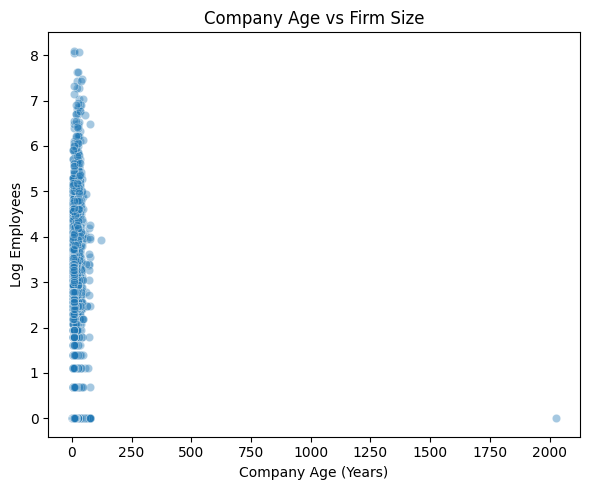

In [12]:
plt.figure(figsize=(6, 5))
sns.scatterplot(
    x=df["company_age"],
    y=df["log_employees_total"],
    alpha=0.4
)
plt.xlabel("Company Age (Years)")
plt.ylabel("Log Employees")
plt.title("Company Age vs Firm Size")
plt.tight_layout()
plt.show()


We compare firm size across regions to identify structural differences in company scale by geography. This helps contextualise subsequent clustering results and highlights regional operating patterns.


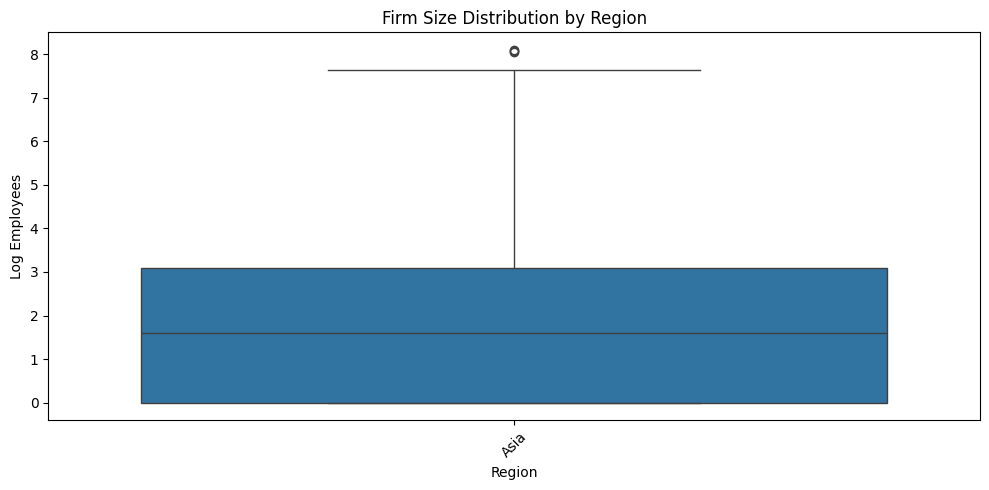

In [13]:
plt.figure(figsize=(10, 5))
sns.boxplot(
    x="Region",
    y="log_employees_total",
    data=df
)
plt.xticks(rotation=45)
plt.xlabel("Region")
plt.ylabel("Log Employees")
plt.title("Firm Size Distribution by Region")
plt.tight_layout()
plt.show()


To understand how IT infrastructure scales with company size, we visualise infrastructure density against employee count. This highlights differences in technology intensity across firms of varying sizes.


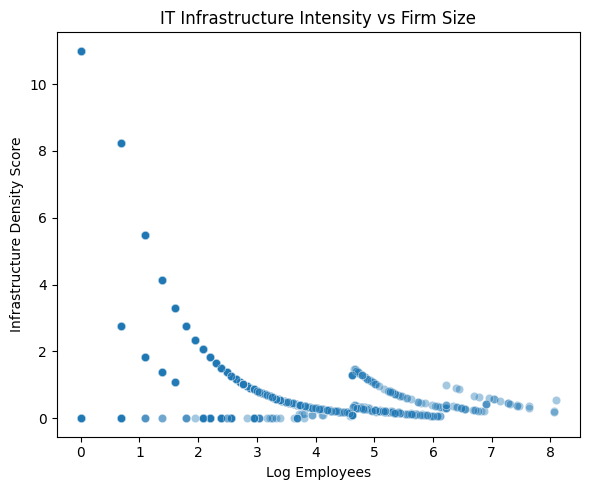

In [14]:
plt.figure(figsize=(6, 5))
sns.scatterplot(
    x=df["log_employees_total"],
    y=df["infra_density_score"],
    alpha=0.4
)
plt.xlabel("Log Employees")
plt.ylabel("Infrastructure Density Score")
plt.title("IT Infrastructure Intensity vs Firm Size")
plt.tight_layout()
plt.show()
